**Detectarea anomaliilor pe tema diferentei intre notele obtinute le Evaluarea Nationala si media claselor V-VIII**

Scopul temei este analiza mediilor elevilor care au sustinut Evaluarea Nationala in anul 2025 si indentificarea anomaliilor intre media finala a examenului si media claselor V-VIII, impartita pe judete si mediul de prevenienta (Rural/Urban).

Anomalii prezente in setul de date:

1. Anomalii locale: supraperformanta sau subperformanta elevilor dintr-un judet sau un mediu, adica media de la Evaluarea Nationala este mult mai mare/mica decat media claselor V-VIII.
       
        ex: un judet cu media generala 7 si media la Evaluarea Nationala 9.

2. Anomalii cluster: un grup de mai multe judete ce prezinta un comportament diferit fata de restul.
        
        ex: mai multe judece cu diferente mari fata de 0 in timp ce celelalte sunt apropiate de 0.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from pyod.models.knn import KNN
from pyod.models.loda import LODA
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist

**Descrierea setului de date**

Am folosit setul de date ce cuprinde rezultatele de la Evaluarea Nationala din 2025. Din intreg fisierul csv au fost pastrate doar coloanele care ne intereseaza adica codul siiir, mediul de provenienta, media finala a examenului, media generala de-a lungul celor 4 clase.

Apoi am realizat mai multe coloane folositoare pentru analiza: diferenta dintre medii, codul judetului, obtinut prin extragerea primelor doua cifre ale codului siiir, si numele judetului, obtinut in urma identificarii codului unic de judet.

Ultima modificare adusa este curatarea setului de intrarile nule.

In [3]:
dataset = pd.read_csv("en_2025.csv", dtype={' COD SIIIR': str})
relevant_colums=[' COD SIIIR','MEDIU','MEDIA','MEDIA V-VIII']

dataset = dataset[relevant_colums]
dataset = dataset.dropna()

dataset['DIFERENTA'] = dataset['MEDIA'] - dataset['MEDIA V-VIII']
dataset.rename(columns={' COD SIIIR': 'COD SIIIR'}, inplace=True)
dataset['COD JUDET'] = dataset['COD SIIIR'].str[:2]


cod_judet = {
    '01':'Alba', '02':'Arad', '03':'Argeș', '04':'Bacău', '05':'Bihor',
    '06':'Bistrița-Năsăud','07':'Botoșani','08':'Brașov','09':'Brăila',
    '10':'Buzău','11':'Caraș-Severin','12':'Cluj','13':'Constanța','14':'Covasna',
    '15':'Dâmbovița','16':'Dolj','17':'Galați','18':'Giurgiu','19':'Gorj',
    '20':'Harghita','21':'Hunedoara','22':'Ialomița','23':'Iași','24':'Ilfov',
    '25':'Maramureș','26':'Mehedinți','27':'Mureș','28':'Neamț','29':'Olt',
    '30':'Prahova','31':'Satu Mare','32':'Sălaj','33':'Sibiu','34':'Suceava',
    '35':'Teleorman','36':'Timiș','37':'Tulcea','38':'Vaslui','39':'Vâlcea',
    '40':'Vrancea','41':'București','42':'București - Sector 1','43':'București - Sector 2',
    '44':'București - Sector 3','45':'București - Sector 4','46':'București - Sector 5',
    '47':'București - Sector 6','48':'Călărași','49':'Giurgiu'
}

dataset['JUDET'] = dataset['COD SIIIR'].str[:2].map(cod_judet)
dataset = dataset.dropna()
dataset.head()

,COD SIIIR,MEDIU,MEDIA,MEDIA V-VIII,DIFERENTA,COD JUDET,JUDET
0,0261100414,URBAN,7.27,9.39,-2.12,02,Arad
1,0261100414,URBAN,6.70,9.82,-3.12,02,Arad
2,0261100414,URBAN,5.85,8.13,-2.28,02,Arad
3,0261100414,URBAN,7.20,9.47,-2.27,02,Arad
4,0261100414,URBAN,5.87,8.63,-2.76,02,Arad


Am mai creat un dataset care contine media pe judet a tuturor sectiilor impartita pe mediu rural, respectiv urban, urmand sa fie stocate in doua noi dataset-uri

In [4]:
dataset_judet_mediu = dataset.groupby(['COD JUDET', 'MEDIU','JUDET'])['DIFERENTA'].mean().reset_index()

dataset_rural = dataset_judet_mediu[dataset_judet_mediu['MEDIU'] == 'RURAL'].reset_index(drop=True)
dataset_urban = dataset_judet_mediu[dataset_judet_mediu['MEDIU'] == 'URBAN'].reset_index(drop=True)

print('RURAL')
print(dataset_rural)

print('URBAN')
print(dataset_urban)

RURAL
   COD JUDET  MEDIU            JUDET  DIFERENTA
0         01  RURAL             Alba  -2.592116
1         02  RURAL             Arad  -2.946134
2         03  RURAL            Argeș  -2.479025
3         04  RURAL            Bacău  -2.496131
4         05  RURAL            Bihor  -2.884100
5         06  RURAL  Bistrița-Năsăud  -2.356061
6         07  RURAL         Botoșani  -2.735408
7         08  RURAL           Brașov  -2.653091
8         09  RURAL           Brăila  -2.357954
9         10  RURAL            Buzău  -2.427080
10        11  RURAL    Caraș-Severin  -2.864228
11        12  RURAL             Cluj  -2.391693
12        13  RURAL        Constanța  -2.695516
13        14  RURAL          Covasna  -3.030489
14        15  RURAL        Dâmbovița  -2.742452
15        16  RURAL             Dolj  -2.905827
16        17  RURAL           Galați  -2.236788
17        18  RURAL          Giurgiu  -2.222032
18        19  RURAL             Gorj  -2.641413
19        20  RURAL         Harghi

Am plotat valorile pentru a oferi o mai buna vizualizare a datelor cu care lucram

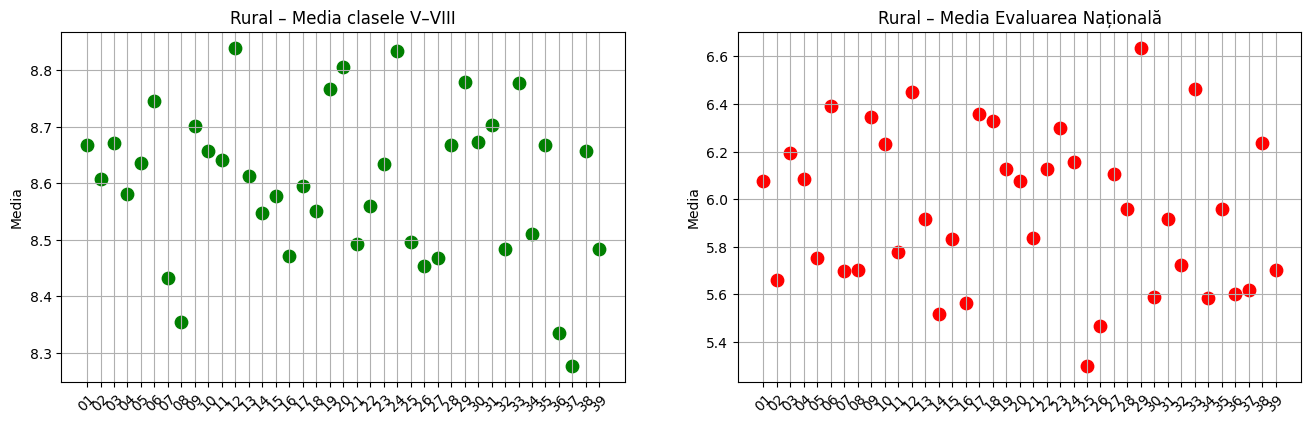

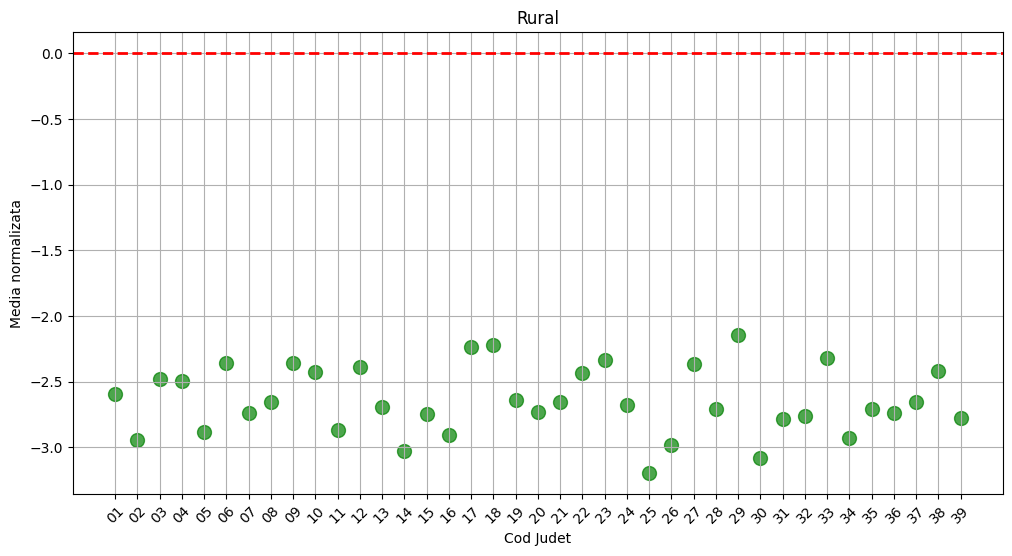

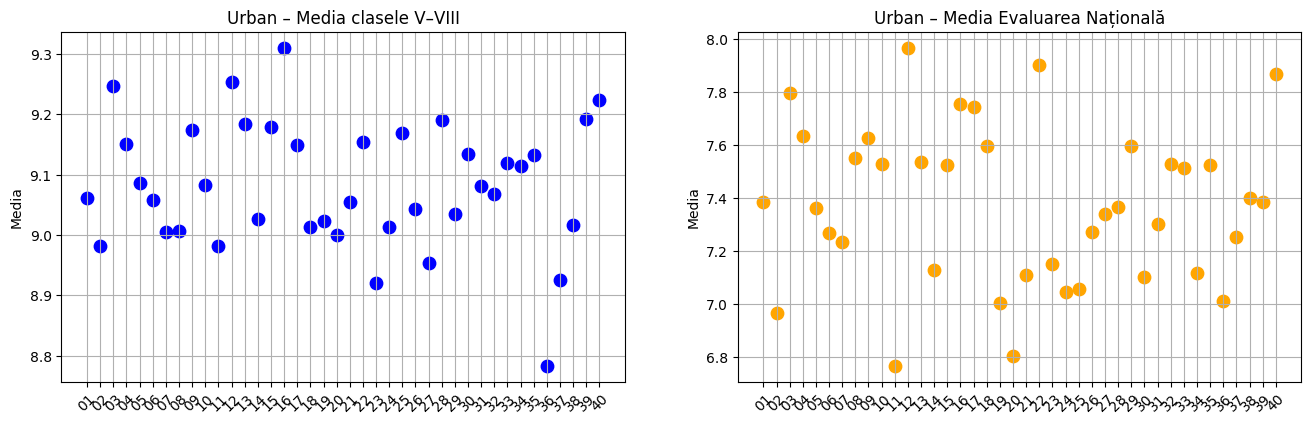

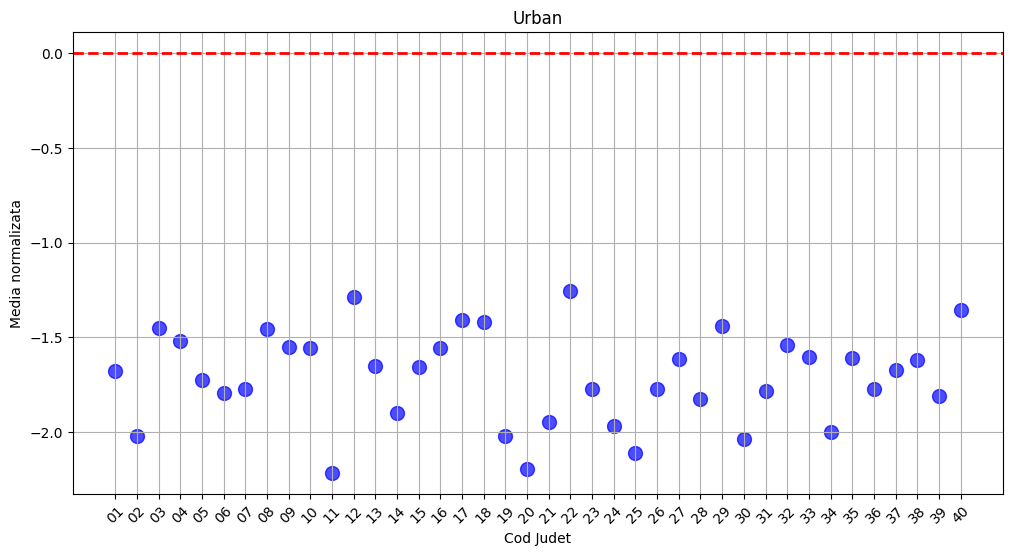

In [5]:
media_58 = dataset.groupby(['COD JUDET', 'MEDIU'])['MEDIA V-VIII'].mean().reset_index()

media_en = dataset.groupby(['COD JUDET', 'MEDIU'])['MEDIA'].mean().reset_index()

media_58_rural = media_58[media_58['MEDIU'] == 'RURAL'].reset_index(drop=True)
media_58_urban = media_58[media_58['MEDIU'] == 'URBAN'].reset_index(drop=True)

media_en_rural = media_en[media_en['MEDIU'] == 'RURAL'].reset_index(drop=True)
media_en_urban = media_en[media_en['MEDIU'] == 'URBAN'].reset_index(drop=True)

plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
plt.scatter(media_58_rural.index, media_58_rural['MEDIA V-VIII'], color='green', s=80)
plt.xticks(media_58_rural.index, media_58_rural['COD JUDET'], rotation=45)
plt.title('Rural – Media clasele V–VIII')
plt.ylabel('Media')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.scatter(media_en_rural.index, media_en_rural['MEDIA'], color='red', s=80)
plt.xticks(media_en_rural.index, media_en_rural['COD JUDET'], rotation=45)
plt.title('Rural – Media Evaluarea Națională')
plt.ylabel('Media')
plt.grid(True)

plt.figure(figsize=(12,6))
plt.scatter(
    dataset_rural.index,            
    dataset_rural['DIFERENTA'],
    s=100,
    color='green',
    alpha=0.7
)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xticks(ticks=dataset_rural.index, labels=dataset_rural['COD JUDET'], rotation=45)
plt.xlabel('Cod Judet')
plt.ylabel('Media normalizata')
plt.title('Rural')
plt.grid(True)
plt.show()

plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 3)
plt.scatter(media_58_urban.index, media_58_urban['MEDIA V-VIII'], color='blue', s=80)
plt.xticks(media_58_urban.index, media_58_urban['COD JUDET'], rotation=45)
plt.title('Urban – Media clasele V–VIII')
plt.ylabel('Media')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.scatter(media_en_urban.index, media_en_urban['MEDIA'], color='orange', s=80)
plt.xticks(media_en_urban.index, media_en_urban['COD JUDET'], rotation=45)
plt.title('Urban – Media Evaluarea Națională')
plt.ylabel('Media')
plt.grid(True)

plt.figure(figsize=(12,6))
plt.scatter(
    dataset_urban.index,           
    dataset_urban['DIFERENTA'],
    s=100,
    color='blue',
    alpha=0.7
)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xticks(ticks=dataset_urban.index, labels=dataset_urban['COD JUDET'], rotation=45)
plt.xlabel('Cod Judet')
plt.ylabel('Media normalizata')
plt.title('Urban')
plt.grid(True)
plt.show()


    - Valoare aproape 0 - diferență mică, comportament normal.
 
    - Valoare pozitivă mare - judetul a supraperformat la EN.

    - Valoare negativă mare - judetul a subperformat la EN.

**Metode de detectare a anomaliilor**

**KNN**
- identitifica anomaliile comparand distantele unui punct la cei mai apropiati vecini.
- anomaliile sunt punctele aflate la o distanta semnificativ de mare fata de ce vecini sai, in comparatie cu majoritatea din punctelor din setul de date
- *avantaj*: functioneaza bine in detectarea anomaliilor locale
- *dezavantaj*: sensibilitate la dataset-uri mari

**LODA**
- potrivit pentru dataset-uri cu diferite caracteristici
- proiecteaza datele in mai multe subspatii unidimensioneaza
- anomaliile sunt detectate pe baza comportamentului lor in acele subspatii, presupunand ca majoritatea punctelor sunt grupate, in vreme ce anomaliile sunt izolate sau rare

Justificare: KNN evidentiaza anomaliile locale, bazate pe relatiile dintre judete, iar LODA surpirnde anomaliile globale, bazate pe distributia statistica

**Implementare** - am folosit metodele KNN si LODA, din libraria POYD cu variabila outlier_fraction (procentul de outliers din numarul total de date) setat la 0.15 pentru a putea avea in fiecare din cele 4 cazuri minim o anomalie detectata

In cazul ambelor metode imprementarea este similara, singura diferenta fiind apelarea:

1. prerpocesam datele, medie 0 si deviate standard 1, pentru ca metodele foslosite sunt sensibile la dimensiunea caracteristicilor

2. antrenarea modelului pe datele noastre, obtinerea anomaly_score-ului si a label-ului (0 daca este inlier sau 1 daca este outlier)

3. plotam datele bazate pe informatiile primite mai sus


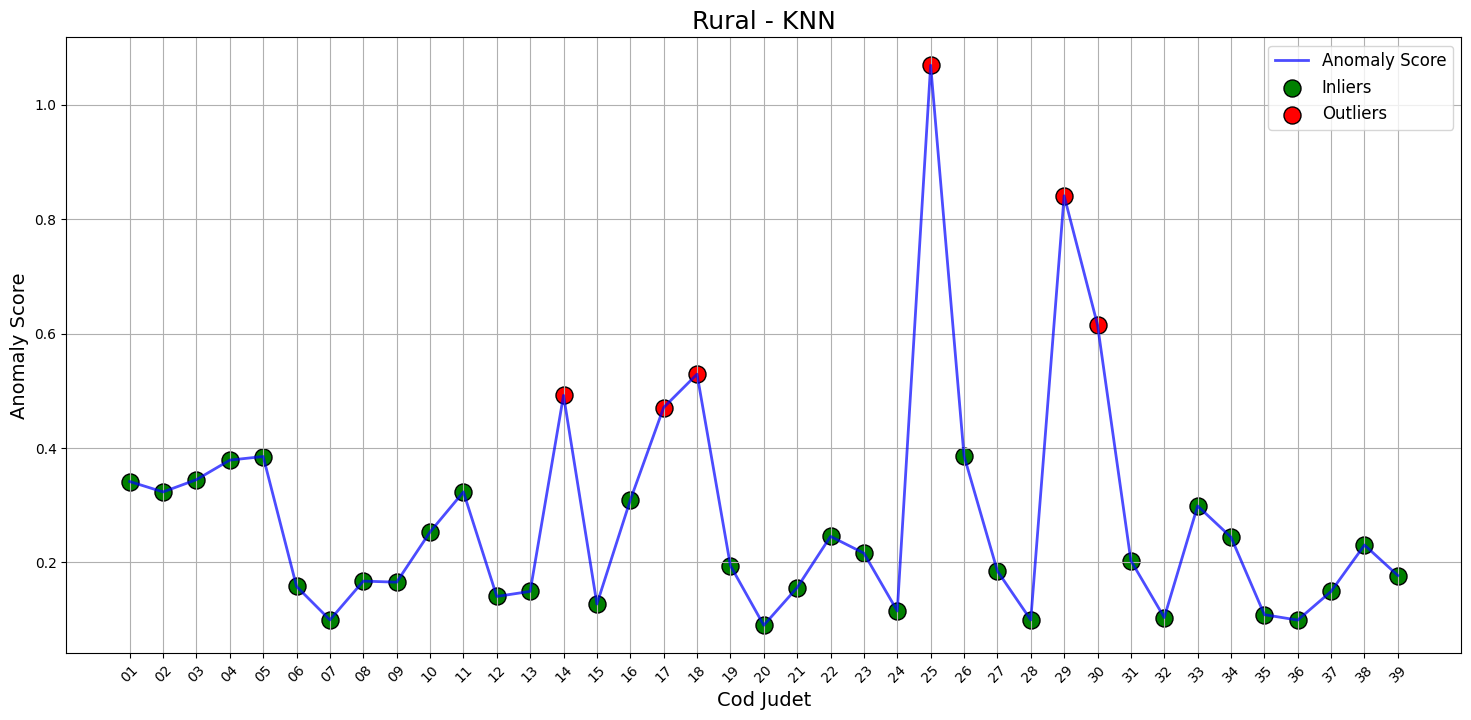

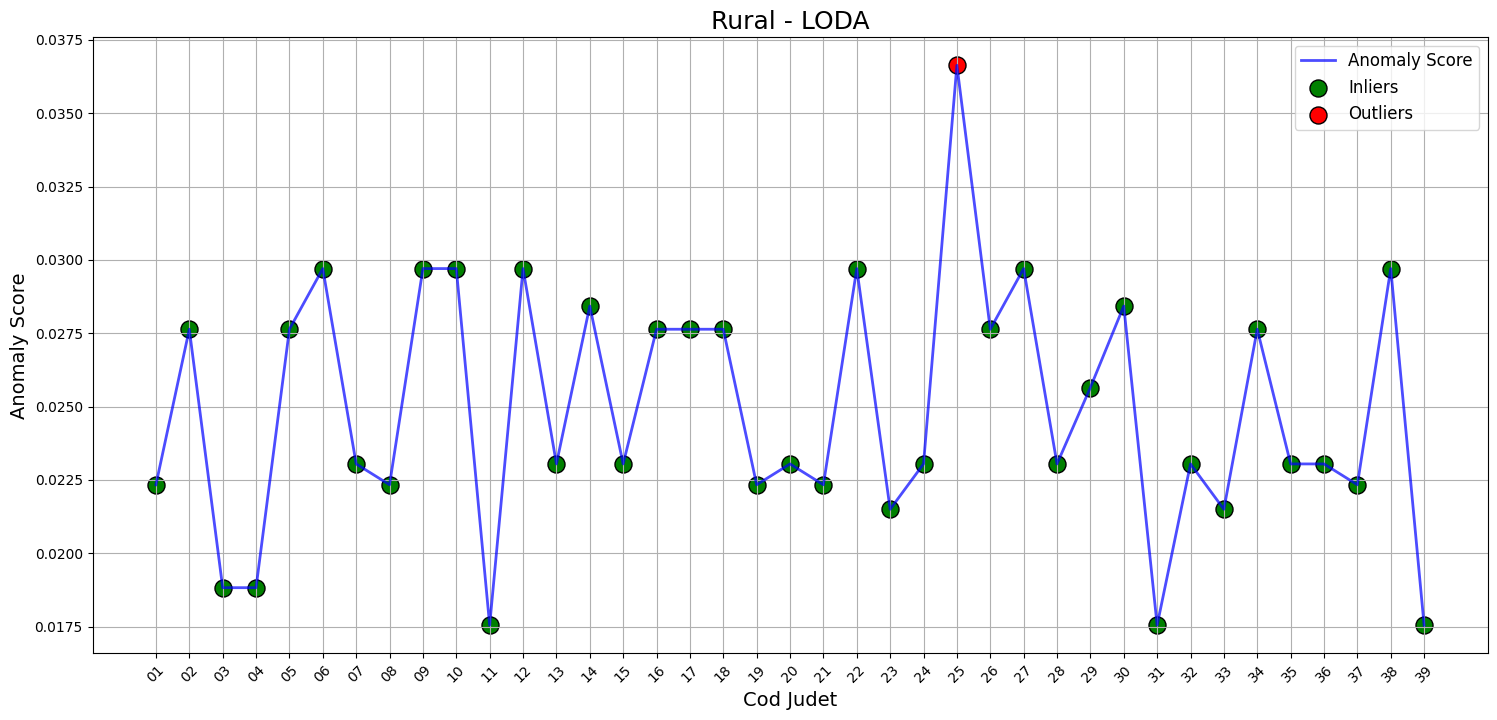

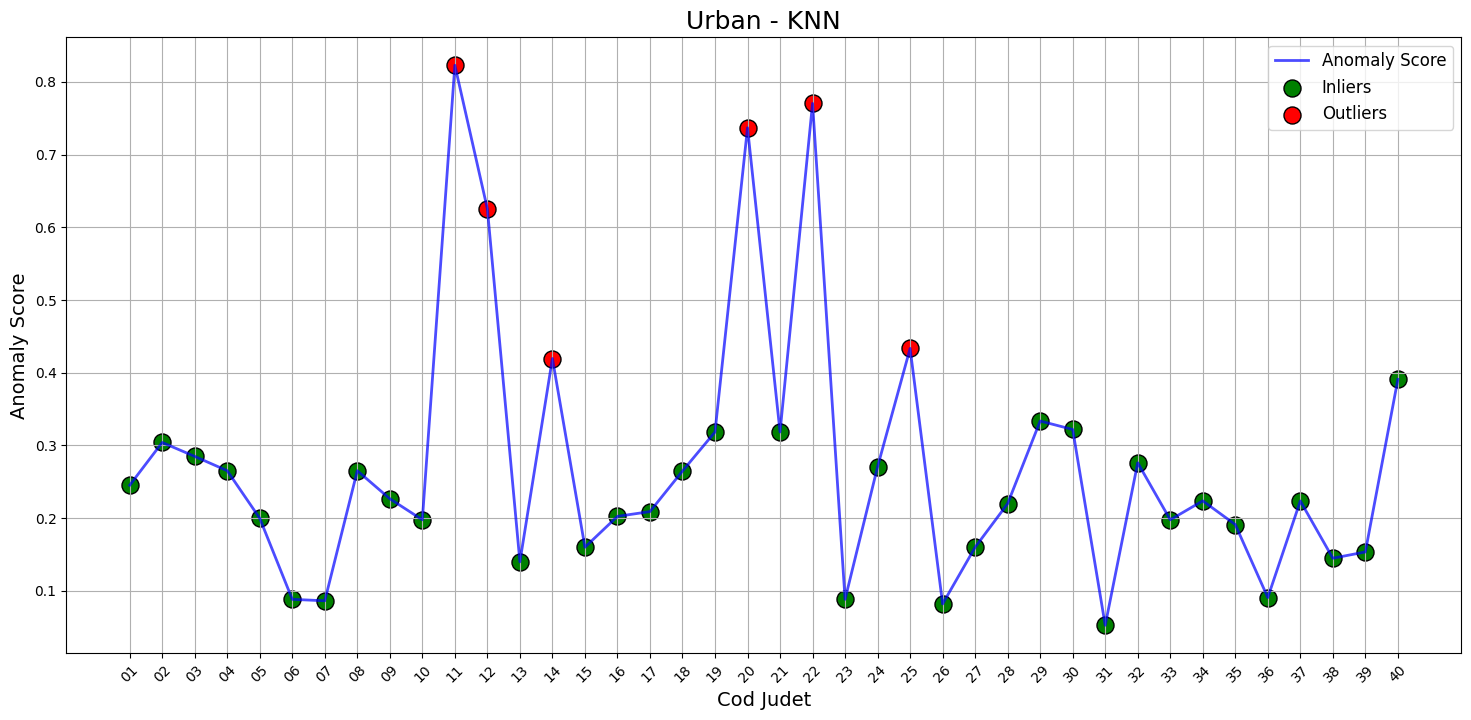

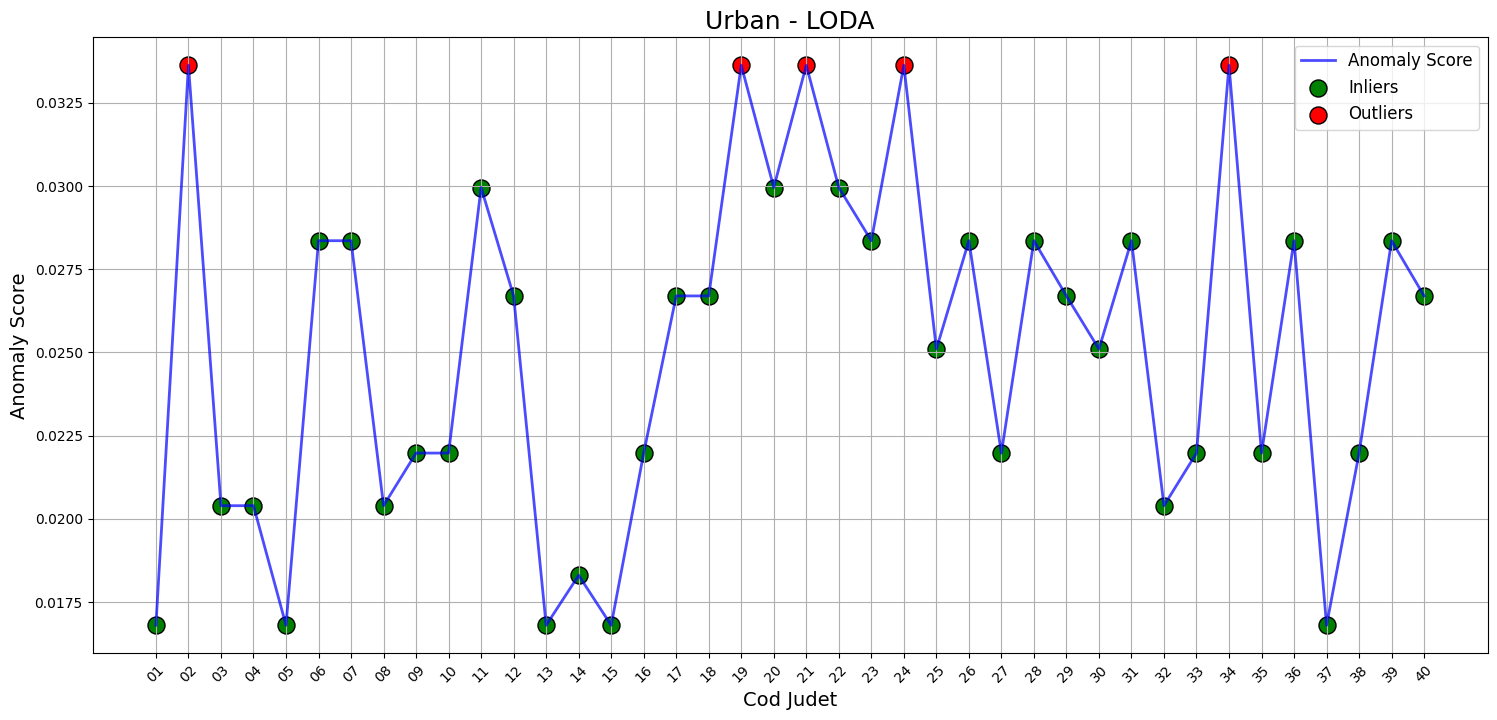

In [14]:
def plot_anomalies_judet(df, env_name, method='KNN', outlier_fraction=0.15):
    classifiers = {'KNN': KNN(contamination=outlier_fraction), 'LODA': LODA(contamination=outlier_fraction)}
    clf = classifiers[method]
    X = df['DIFERENTA'].values
    scaler = StandardScaler()
    X = scaler.fit_transform(X.reshape(-1,1))
    
    clf.fit(X)
    scores_pred = clf.decision_scores_
    y_pred = clf.labels_

    plt.figure(figsize=(18,8))
    plt.plot(
        np.arange(len(X)),
        scores_pred,
        color='blue',
        alpha=0.7,
        linewidth=2,
        label=f'Anomaly Score'
    )
    plt.scatter(
        np.arange(len(X))[y_pred==0], 
        scores_pred[y_pred==0], 
        c='green', 
        s=150, 
        edgecolor='k',
        label='Inliers'
    )
    plt.scatter(
        np.arange(len(X))[y_pred==1],
        scores_pred[y_pred==1],
        c='red',
        s=150,
        edgecolor='k',
        label='Outliers'
    )
    plt.xticks(
        np.arange(len(X)),
        df['COD JUDET'],
        rotation=45
    )
    plt.xlabel('Cod Judet', fontsize=14)
    plt.ylabel('Anomaly Score', fontsize=14)
    plt.title(f'{env_name} - {method}', fontsize=18)
    plt.grid(True)
    plt.legend(fontsize=12)
    plt.show()


plot_anomalies_judet(dataset_rural, 'Rural', method='KNN', outlier_fraction=0.15)
plot_anomalies_judet(dataset_rural, 'Rural', method='LODA', outlier_fraction=0.15)
plot_anomalies_judet(dataset_urban, 'Urban', method='KNN', outlier_fraction=0.15)
plot_anomalies_judet(dataset_urban, 'Urban', method='LODA', outlier_fraction=0.15)

**Evaluarea performantei**

Putem observa, din grafice niste diferente intre cele doua modele, asa ca o sa folosim metode metrice sa evaluam diferentele (dunn-index,cohesion-score,silhouette-score)

1. dunn-index
   * evalueaza cat de bine sunt izolate anomaliile cluster fata de distributia generala a datelor
   * masoara raportul dintre distanta minima intre clustere si dispersia maxima din interiorul clusterelor
   * un indice mare sugereaza clustere mai compacte si mai separate, iar un indice mic separare si compactare mai slaba

2. cohesion-score
    * masoara cat de compacte sunt clusterele, adica cat de apropiate sunt punctele din fiecare cluster de centroid
    * formula: $$\text{Cohesion} = \frac{1}{K} \sum_{k=1}^{K} \left( \frac{1}{|C_k|} \sum_{x_i \in C_k} d(x_i, \mu_k) \right)$$
      unde: K = nr de clustere, Ck = multimea punctelor din clusterul k, |Ck| = nr de puncte din clusterul k, xi = un punct din cluster, miuk = centrul clusterului k, d(xi,miuk) = distanta dintre punct si centru
   * un scor mic sugereaza ca datele clasificate la inlier au componente similare, anomaliile fiind bine determinate

3. silhouette-score:
    * evalueaza calitatea clusterelor in dataset, adica cat de bine sunt separate observatiile notate ca inliers fata de cele outliers
    * valori intre -1 si 1
       * valori apropiate de 1 = separare buna
       * valori apropiate de 0 = suprapunere
       * valori negative = separare slaba
    

 

In [7]:
def dunn_index(X, labels):
    clusters = np.unique(labels)
    if len(clusters) < 2:
        return None
    centers = np.array([X[labels == c].mean(axis=0) for c in clusters])
    inter_cluster_dist = cdist(centers, centers)
    min_inter = np.min(inter_cluster_dist[np.nonzero(inter_cluster_dist)])
    intra_cluster_dist = max(
        np.max(cdist(X[labels == c], [centers[i]]))
        for i, c in enumerate(clusters)
    )
    return min_inter / intra_cluster_dist

def cohesion_score(X, labels):
    clusters = np.unique(labels)
    cohesion = np.mean([
        np.mean(cdist(X[labels == c], [X[labels == c].mean(axis=0)]))
        for c in clusters
    ])
    return cohesion

def evaluate_anomaly_models(df, outlier_fraction=0.2):
    classifiers = {
        'KNN': KNN(contamination=outlier_fraction),
        'LODA': LODA(contamination=outlier_fraction)
    }
    
    results = {}
    # Media diferențelor pentru toate județele
    avg_distribution = df['DIFERENTA'].mean()
    
    for name, clf in classifiers.items():
        X = df['DIFERENTA'].values.reshape(-1, 1)
        clf.fit(X)
        y_pred = clf.labels_
        scores = clf.decision_scores_
        
        silhouette = silhouette_score(X, y_pred) if len(np.unique(y_pred)) > 1 else None
        dunn = dunn_index(X, y_pred)
        cohesion = cohesion_score(X, y_pred)
        
        results[name] = {
            'predicted_outliers': np.sum(y_pred==1),
            'average_distribution': avg_distribution,
            'silhouette_score': silhouette,
            'dunn_index': dunn,
            'cohesion_score': cohesion,
            'outlier_judete': df[y_pred==1][['COD JUDET', 'DIFERENTA']]
        }
    
    return results


In [8]:
results_urban = evaluate_anomaly_models(dataset_urban, outlier_fraction=0.15)
results_rural = evaluate_anomaly_models(dataset_rural, outlier_fraction=0.15)

def print_results(results, mediu_name):
    print(f"\n=== {mediu_name} ===")
    for clf_name, res in results.items():
        print(f"\n{clf_name}:")
        print(f" Predicted outliers: {res['predicted_outliers']}")
        print(f" Average value of distribution: {res['average_distribution']:.3f}")
        print(f" Silhouette score: {res['silhouette_score']}")
        print(f" Dunn Index: {res['dunn_index']}")
        print(f" Cohesion Score: {res['cohesion_score']}")
        print(" Outlier județe:")
        print(res['outlier_judete'].to_string(index=False))

# Afișare
print_results(results_urban, "Urban")
print_results(results_rural, "Rural")


=== Urban ===

KNN:
 Predicted outliers: 6
 Average value of distribution: -1.708
 Silhouette score: 0.3682801575865506
 Dunn Index: 0.24397023507683527
 Cohesion Score: 0.26537459623806503
 Outlier județe:
COD JUDET  DIFERENTA
       11  -2.217143
       12  -1.287638
       14  -1.898046
       20  -2.196409
       22  -1.252635
       25  -2.112595

LODA:
 Predicted outliers: 5
 Average value of distribution: -1.708
 Silhouette score: 0.2776799047112629
 Dunn Index: 0.5882893856281316
 Cohesion Score: 0.10336666120936285
 Outlier județe:
COD JUDET  DIFERENTA
       02  -2.018621
       19  -2.022098
       21  -1.945291
       24  -1.969656
       34  -1.999243

=== Rural ===

KNN:
 Predicted outliers: 6
 Average value of distribution: -2.643
 Silhouette score: 0.3827136297336548
 Dunn Index: 0.019996558686532953
 Cohesion Score: 0.30806152665811964
 Outlier județe:
COD JUDET  DIFERENTA
       14  -3.030489
       17  -2.236788
       18  -2.222032
       25  -3.196858
       29  -

**Interpretarea performantei**

 1. silhouette-score
    * Urban: KNN (0.368) > LODA (0.278) -> KNN are o separare moderata, dar LODA evidentiaza mai putine grupuri distincte
    * Rural: KNN (0.383) < LODA (0.403) -> LODA separa mai bine clusterele, chiar daca indetifica mai putine anomalii
 2. dunn-index
    * Urban: LODA (0.588) > KNN (0.244) -> LODA identifica judete cu deviatii mai clare, dar mai putine
    * Rural: LODA (1.173) > KNN (0.020) -> LODA gaseste o anomalie puternica si bine definta, iar KNN percepe mai multe judete ca anomalii, dar usoare si cu separare slaba
 3. cohesion-score
    * Urban: LODA (0.103) < KNN (0.265) -> anomaliie detectate de LODA sunt mai centrate
    * Rural: LODA (0.101) < KNN (0.308) -> LODA identifica o singura anomalie clara, iar KNN mai multe judete


Am ales un judet care apare in aproape toate graficele ca anomalie pentru a-l analiza din interior, aplicand metodele KNN si LODA pentru evidentia numarul de inliers si outliers al scolilor din acest judet

KNN - Judet 25: Outliers = 201, Inliers = 1386


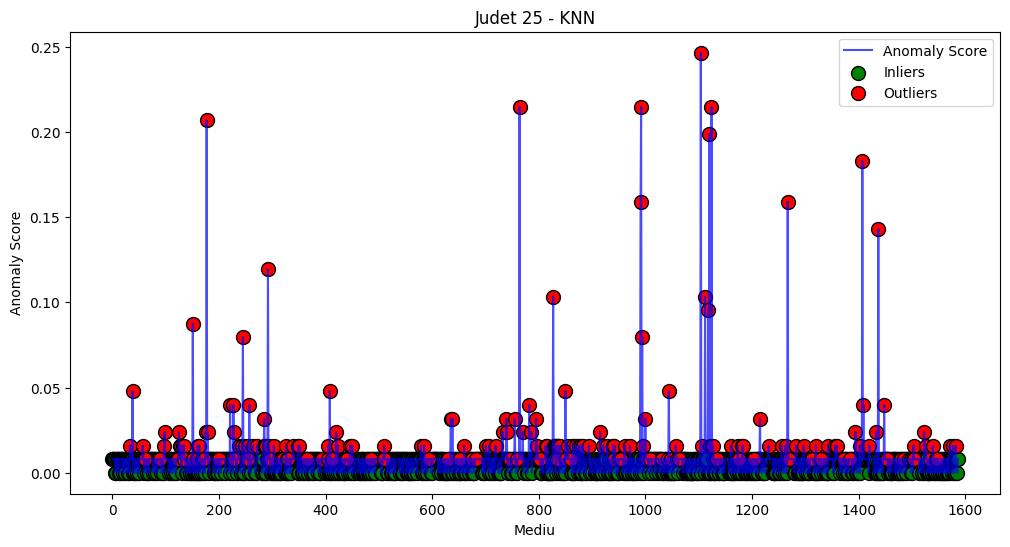

LODA - Judet 25: Outliers = 218, Inliers = 1369


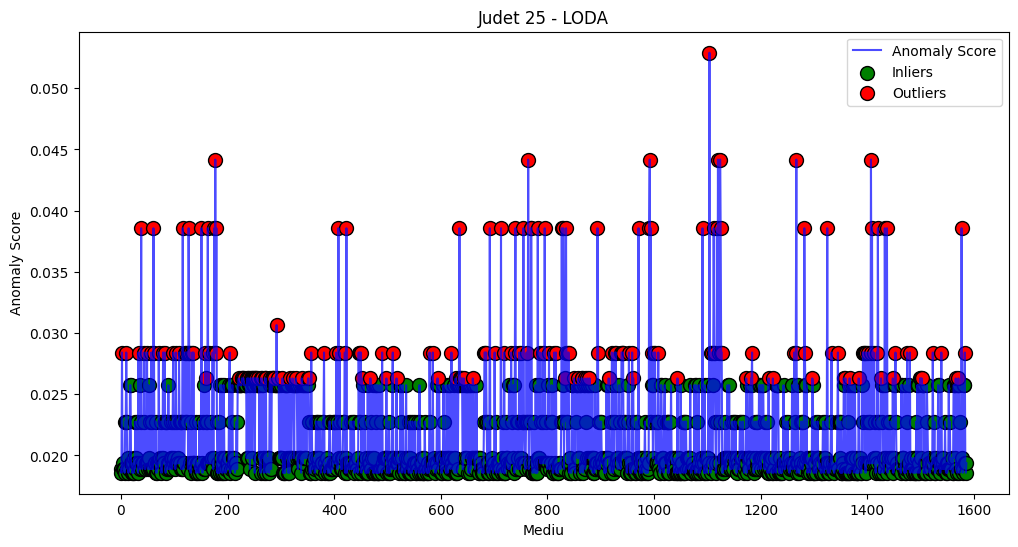

In [13]:
judet_25 = dataset[dataset['COD JUDET'] == '25'].copy()

# Funcție generală pentru plotare și calcul outliers/inliers
def plot_anomalies_judet25(df, method='KNN', outlier_fraction=0.2):
    if df.shape[0] < 2:
        print("Nu există suficiente date pentru metoda KNN, folosește LODA sau mai multe puncte")
        return
    
    classifiers = {
        'KNN': KNN(contamination=outlier_fraction),
        'LODA': LODA(contamination=outlier_fraction)
    }
    
    clf = classifiers[method]
    
    # Folosim DIFERENTA
    X = df['DIFERENTA'].values.reshape(-1, 1)
    
    # Normalizăm doar pentru stabilitate numerică
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    clf.fit(X_scaled)
    y_pred = clf.labels_  # 0 inliers, 1 outliers
    scores = clf.decision_scores_
    
    plt.figure(figsize=(12,6))
    plt.plot(np.arange(len(X_scaled)), scores, color='blue', alpha=0.7, label='Anomaly Score')
    plt.scatter(np.arange(len(X_scaled))[y_pred==0], scores[y_pred==0], c='green', s=100, label='Inliers', edgecolor='k')
    plt.scatter(np.arange(len(X_scaled))[y_pred==1], scores[y_pred==1], c='red', s=100, label='Outliers', edgecolor='k')
    plt.xlabel('Mediu')
    plt.ylabel('Anomaly Score')
    plt.title(f'Judet 25 - {method}')
    plt.legend()
    
    
    # Afisam outliers/inliers sub grafic
    num_outliers = np.sum(y_pred==1)
    num_inliers = np.sum(y_pred==0)
    print(f"{method} - Judet 25: Outliers = {num_outliers}, Inliers = {num_inliers}")
    
    plt.show()

# Apelam functia pentru KNN si LODA
plot_anomalies_judet25(judet_25, method='KNN', outlier_fraction=0.15)
plot_anomalies_judet25(judet_25, method='LODA', outlier_fraction=0.15)

**Concluzii**

Scopul acestei teme a fost sa indentificam judetele care se abat seminificativ de la tendinta generala, fie ea subperformanta sau supraperformanta, analizand diferenta dintre media la Evaluarea Nationala si media elevilor in clasele V-VII

Rezultate:

**Urban**

 * Media diferentelor: -1.708 -> usoara tendinta de subperformanta
 * *KNN*
     * Judete indetificate: 6 (11,12,14,20,22,25)
     * silhouette-score = 0.368 si dunn-index = 0.244 indica o separare moderata in clustere si o coeziune rezonabila
       
 * *LODA*
     * Judete indetificate: 5 (02,19,21,24,34)
     * slihouette-score = 0.278 si dunn-index = 0.588 arata o separare mai buna in clustere decat la KNN
     * cohesion-socre = 0.103 arata ca LODA indetifica anomalii mai clar, mai putin dispersate

**Rural**

* Media diferentelor: -2.643 -> o subperformanta pronuntata, alarmanta
* *KNN*
   * Judete indetificate: 6 (14,17,18,25,29,30)
   * silhouette-score = 0.383 si dunn-index = 0.020 prezinta o separare foarte slaba intre clustere, posbili din cauza unei variatii mai mari intre judete

* *LODA*
   * Judete identificare: 1 (25)
   * dunn-index = 1.173, foarte mare, sugereaza o anomalie clara si bine separata
   * cohesion-score = 0.101 confirma ca este bine definita si concentrata

**Observatii:**
1. Judetul 25 apare constant ca anomalie in ambele medii
2. KNN tinde sa indetifice mai multe anomalii, fiind mai sensibil la variatii locale, in timp ce LODA se concentreaza pe deviatiile majore
3. Diferete medii negative -> superformante la Evaluarea Nationala, mai accentuata in mediile rurale

**Constatari:**
1. **Cea mai buna separare a clusterelor:** LODA prezinta valori mai mare pentru silhouette-score si dunn-index, fiind mai potrivita pentru setul nostru de date cu deviatii definite.
2. **Cea mai buna coeziune:** KNN arata valori mai mici ale coeziunii, indicand o grupare mai dispersata, totusi uneori LODA indetifica mai bine anomaliile
3. **Detectarea de outliers:** LODA detecteaza anomalii mai evidente si bine definite, benefic pentru seturi de date cu deviatii mari, KNN poate detecta mai putine anomalii majore, dar ofera o abordare conservativa
4. **Consistenta distributiei:** LODA ofera o imagine clara asupra variatiilor subtile si evidentiaza deviatiile mari, KNN reflecteaza mai multe judete ca outliers, inlcusiv cele cu abateri mai mici

**Bibliografie:**

- https://data.gov.ro/dataset/rezultate_evaluare_2025
- https://pyod.readthedocs.io/en/latest/
- https://medium.com/dataman-in-ai/anomaly-detection-with-pyod-b523fc47db9
- https://youtu.be/gs9E7E0qOIc?si=p284EsRC8oespvwF
- https://youtu.be/QPjG_313GOw?si=uA5w1PYHXoGqq8DL
- https://www.analyticsvidhya.com/blog/2019/02/outlier-detection-python-pyod/